# Overview
## ML Model for Predicting RSI

### RSI
RSI is the a classic indicator used to simply measure the strength of the average direction of a price action that is normalized between 0 and 100. 

#### Formula
$$
\begin{align}
RS &= \frac{Avg_{Gain}}{Avg_{Loss}} \\
RSI &= 100 - \frac{100}{1+RS}
\end{align}
$$

### Model
The model created should be able to take an average of input, determine the average gain and loss of the period. Then average those two averages and that will generate the relative strength of the trend. But then we need to teach the model to normalize that into a boundary of 0 - 100.

### Approaches
1) Develop an model that can first predict the relative strength of the period. Then extend the model to normalized the strength into a range of 0 - 100. with the 100 bias and division of rs.

In [95]:
import tensorflow as tf;
import pandas as pd;
import numpy as np;
import talib as ta;
import math;
import matplotlib.pyplot as plt;

In [80]:
def average_gains(chunk, period):
    def gains(chunk):
        gain = 0
        for i in range(1, len(chunk)):
            if (chunk[i-1] < chunk[i]):
                gain += chunk[i] - chunk[i-1]
        return gain
    avg_total_gain = gains(chunk)/period
    return avg_total_gain
    
def average_losses(chunk, period):
    def losses(chunk):
        loss = 0
        for i in range(1, len(chunk)):
            if (chunk[i - 1] > chunk[i]):
                loss += chunk[i-1] - chunk[i]
        return loss
    
    avg_total_losses = losses(chunk)/period
    return avg_total_losses

def relative_strength_calculation(chunk, period):
    avg_total_gain = average_gains(chunk, period)
    avg_total_losses = average_losses(chunk, period)
    if avg_total_losses == 0:
        return 1
    return avg_total_gain/avg_total_losses

def rs_set_builder(data: pd.DataFrame, column: str, period: int):
    period_chunks = np.array([np.array(data[i:i+period][column]) for i in range(0, data.shape[0] - period)])
    rs = np.array([relative_strength_calculation(period_chunks[i], period) for i in range(len(period_chunks))])
    
    x_train, x_test = period_chunks[0:math.ceil(len(period_chunks)/2)], period_chunks[math.ceil(len(period_chunks)/2):]
    y_train, y_test = rs[0:math.ceil(len(rs)/2)], rs[math.ceil(len(rs)/2):]
    
    return (
        (x_train, x_test),
        (y_train, y_test)
    )

In [81]:
spx_data = pd.read_csv(
    './data/SPX_2019_1min.csv',
    header=None,
    names=["date", "open", "high", "low", "close"],
    parse_dates=["date"],
    index_col=['date']
)

In [82]:
(
    (spx_rs_x_train, spx_rs_x_test),
    (spx_rs_y_train, spx_rs_y_test)
) = rs_set_builder(spx_data, "close", 7)

In [83]:
rs_model = tf.keras.models.Sequential()
rs_model.add(tf.keras.layers.Input(shape=(spx_rs_x_train.shape[1],), dtype="float64"))
rs_model.add(tf.keras.layers.Dense(256, activation="relu"))
rs_model.add(tf.keras.layers.Dense(1))

rs_model.compile(optimizer='adam', loss="mean_squared_error")

In [84]:
rs_model.fit(spx_rs_x_train, spx_rs_y_train, epochs=25, verbose=1)

Epoch 1/25
1528/1528 [==============================] - 1s 411us/step - loss: 6675.5391
Epoch 2/25
1528/1528 [==============================] - 1s 395us/step - loss: 492.5317
Epoch 3/25
1528/1528 [==============================] - 1s 392us/step - loss: 575.8026
Epoch 4/25
1528/1528 [==============================] - 1s 399us/step - loss: 619.9811
Epoch 5/25
1528/1528 [==============================] - 1s 395us/step - loss: 579.6748
Epoch 6/25
1528/1528 [==============================] - 1s 397us/step - loss: 565.6384
Epoch 7/25
1528/1528 [==============================] - 1s 464us/step - loss: 563.0098
Epoch 8/25
1528/1528 [==============================] - 1s 445us/step - loss: 571.2115
Epoch 9/25
1528/1528 [==============================] - 1s 397us/step - loss: 551.9761
Epoch 10/25
1528/1528 [==============================] - 1s 395us/step - loss: 523.7345
Epoch 11/25
1528/1528 [==============================] - 1s 398us/step - loss: 528.8813
Epoch 12/25
1528/1528 [=================

In [85]:
rs_model.evaluate(spx_rs_x_test, spx_rs_y_test)

1528/1528 [==============================] - 1s 302us/step - loss: 400.2777


400.2777099609375

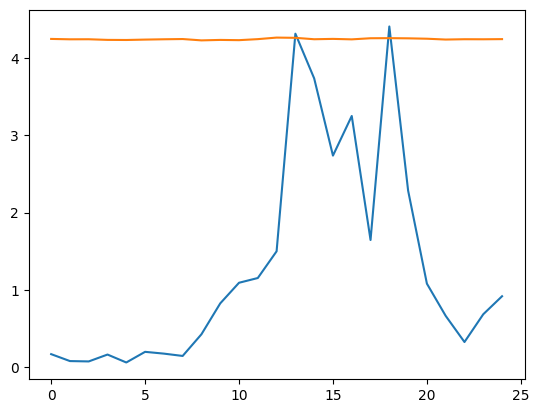

In [140]:
plt.plot(spx_rs_y_test[:25])
plt.plot(rs_model.predict(spx_rs_x_test[:25], verbose=0))

# Initial Thoughts on Generating Simple RS model
Right now it does seem like the model is not able to learn what relative strength is given the chunk of close prices. I believe this might be due to the neurons not able to regressively extract what is consider a gain avg and a loss avg... Thus they can not "learn" to divide it by each other. I might first need to rain a two models to first extract the avg gain and avg loss... Then pass those into a model for it to learn how then generate the rs average. Going to try and see if I can train it to recognize gains and then average those.

In [87]:
spx_avg_gains = np.array([average_gains(spx_data[i:i+7]['close'], 7) for i in range(len(spx_data)-7)])
spx_avg_gains_y_train, spx_avg_gains_y_test = spx_avg_gains[0:math.ceil(len(spx_avg_gains)/2)], spx_avg_gains[math.ceil(len(spx_avg_gains)/2):]

In [135]:
avg_gain_model = tf.keras.models.Sequential()
avg_gain_model.add(tf.keras.layers.Input(shape=spx_rs_x_train.shape[1], dtype="float64"))
avg_gain_model.add(tf.keras.layers.LayerNormalization())
avg_gain_model.add(tf.keras.layers.Dense(2056, activation="relu"))
avg_gain_model.add(tf.keras.layers.LayerNormalization())
avg_gain_model.add(tf.keras.layers.Dense(1))

avg_gain_model.compile(optimizer='adam', loss="mean_squared_error")

In [136]:
avg_gain_model.fit(spx_rs_x_train, spx_avg_gains_y_train, epochs=3)

Epoch 1/3
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0994
Epoch 2/3
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0600
Epoch 3/3
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0579


In [137]:
avg_gain_model.evaluate(spx_rs_x_test, spx_avg_gains_y_test)

1528/1528 [==============================] - 2s 954us/step - loss: 0.0601


0.06014028564095497

[[0.25424704]]
[0.08571429]


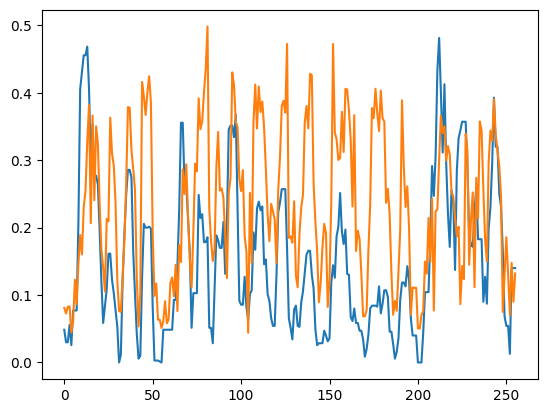

In [139]:
plt.plot(spx_avg_gains_y_test[:256])
plt.plot(avg_gain_model.predict(spx_rs_x_test[:256], verbose=0))
print(avg_gain_model.predict(spx_rs_x_test[100:101], verbose=0))
print(spx_avg_gains_y_test[100:101])

# Thoughts on Generating Average Gains
The model is having trouble fitting the average gain... I would have thought that it could better average a single a group of prices. But I think the model is having trouble isolating the positive gains. Maybe we need a model that will attempt to learn what are the gainers and the losses in a model. Although if we isolated those features manually, via feature engineering it might prove to me easier. I would like the model to purely discover and learn how to create RSI from scratch.

## Strategy
Make the model first classify if a tick was a gain or a loss. Then use that classification context to then determine the gain and loss of a period. That then could be used to get a avg gain and loss of a period. Then use those to produce a RS.

In [146]:
def classify_data_for_gain_or_loss(data: pd.DataFrame, column: str, period: int):
    
    # Returns an array of length period - 1, and return an array of 1 if gain and 0 if loss
    def loss_or_gain(chunk, period):
        gain_or_loss = [];
        for i in range(1, period):
            if chunk[i-1] < chunk[i]:
                gain_or_loss.append(1)
            else:
                gain_or_loss.append(0)
        return gain_or_loss
    
    period_chunks = np.array([np.array(data[i:i+period][column]) for i in range(0, data.shape[0] - period)])
    classify_gain_or_loss = np.array([loss_or_gain(period_chunks[i], period) for i in range(len(period_chunks))])
    
    y_train, y_test = classify_gain_or_loss[0:math.ceil(len(classify_gain_or_loss)/2)], classify_gain_or_loss[math.ceil(len(classify_gain_or_loss)/2):]
    
    return (y_train, y_test)

In [147]:
classify_gain_or_loss_y_train, classify_gain_or_loss_y_test = classify_data_for_gain_or_loss(spx_data, "close", 7)

In [258]:
classify_gain_or_loss_model = tf.keras.models.Sequential()
classify_gain_or_loss_model.add(tf.keras.layers.Input(shape=(spx_rs_x_train.shape[1],), dtype="float64"))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(1024, activation='relu'))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(6, activation='softmax'))
classify_gain_or_loss_model.compile(optimizer='adam', loss='kl_divergence', metrics=['accuracy'])

In [259]:
classify_gain_or_loss_model.fit(spx_rs_x_train, classify_gain_or_loss_y_train, epochs=5)

Epoch 1/5
1528/1528 [==============================] - 1s 654us/step - loss: 41.5811 - accuracy: 0.2066
Epoch 2/5
1528/1528 [==============================] - 1s 579us/step - loss: 41.5811 - accuracy: 0.2066
Epoch 3/5
1528/1528 [==============================] - 1s 568us/step - loss: 41.5811 - accuracy: 0.2066
Epoch 4/5
1528/1528 [==============================] - 1s 572us/step - loss: 41.5810 - accuracy: 0.2066
Epoch 5/5
1528/1528 [==============================] - 1s 581us/step - loss: 41.5811 - accuracy: 0.2066


In [260]:
classify_gain_or_loss_model.evaluate(spx_rs_x_test, classify_gain_or_loss_y_test)

1528/1528 [==============================] - 1s 461us/step - loss: 41.0595 - accuracy: 0.2168


[41.0594596862793, 0.21681742370128632]

In [261]:
print(classify_gain_or_loss_y_test[1:10])
pred = classify_gain_or_loss_model.predict(spx_rs_x_test)
for pred_i in range(len(pred)):
    if 1.0 in pred[pred_i]:
        print("found a point?")
        print(classify_gain_or_loss_y_test[pred_i])
        print(pred[pred_i])

[[0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 1 0 1]
 [0 0 1 0 1 0]
 [0 1 0 1 0 0]
 [1 0 1 0 0 1]
 [0 1 0 0 1 1]]
1528/1528 [==============================] - 1s 374us/step
found a point?
[1 0 0 1 0 0]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 0 1 0 0 0]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 1 0 0 0 0]
[0. 1. 0. 0. 0. 0.]
found a point?
[1 0 0 0 0 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 0 0 0 1 0]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 0 0 1 0 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 0 1 0 1 0]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 1 0 1 0 0]
[0. 1. 0. 0. 0. 0.]
found a point?
[1 0 1 0 0 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 1 0 0 1 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[1 0 0 1 1 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 0 1 1 1 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[0 1 1 1 1 0]
[0. 1. 0. 0. 0. 0.]
found a point?
[1 1 1 1 0 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[1 1 1 0 1 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[1 1 0 1 1 1]
[0. 1. 0. 0. 0. 0.]
found a point?
[1 0 1